# Training GPT-2 model on Bangla books

Necessary imports for the project

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import random
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2LMHeadModel
from transformers import WEIGHTS_NAME, CONFIG_NAME
from tqdm import tqdm

2022-04-04 10:28:17.728338: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/anaconda/envs/Project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparing dataset
Initialize the project root, data, and model directories. `processed_data` directory contains selected books from renowned authors only.

In [2]:
# get data and model directories
project_root = Path('__file__').resolve().parents[1]
data_dir = project_root / 'processed_data/'
model_dir = project_root / 'models/bn_gpt2'
os.makedirs(model_dir, exist_ok=True) # Create if does not exist

Get list of files in the data directory

In [3]:
filenames = [str(file) for file in Path(data_dir).glob('**/*.txt')]

Then we randomly shuffle the filenames list and select 100 files.

In [16]:
random.shuffle(filenames)
filenames = filenames[:100]

Split the files for training, validation, and testing. We are using 70% for training, 15% for validation and 15% for testing.

In [18]:
train_size = int(len(filenames) * 0.70)
train_filenames = filenames[:train_size]

validation_size = train_size + int(len(filenames) * 0.15)
validation_filenames = filenames[train_size:validation_size]

test_filenames = filenames[validation_size:]

`create_dataset` creates a Tensorflow Dataset from a list of filenames with a length of `max_sequence_length - 1`. `inputs` list contains first `max_sequence_length - 1` number of words except the last word, and `labels` list contains last `max_sequence_length - 1` words except the first word. `skip_size` defines how many words to skip from a tokenized string when creating `inputs` and `labels` list.

In [6]:
def create_dataset(tokenizer, filenames, max_sequence_length, skip_size):
    BATCH_SIZE = 12     # batch size 12 is needed for transformer
    BUFFER_SIZE = 1000  # for random shuffling
    inputs = []
    labels = []

    for file in tqdm(filenames):
        with open(file, 'r') as f:
            for line in f:
                string_tokenized = tokenizer.encode(line)
                for i in range(0, len(string_tokenized) - max_sequence_length + 1, skip_size):
                    ex = string_tokenized[i:i + max_sequence_length]
                    inputs.append(ex[:-1])
                    labels.append(ex[1:])
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
    return dataset

Create a tokenizer from pretrained model and add special tokens for padding, beginning, and end of sentence.

In [7]:
tokenizer = AutoTokenizer.from_pretrained("flax-community/gpt2-bengali")
tokenizer.add_special_tokens(
    {'pad_token': '<pad>', 'bos_token': '<s>', 'eos_token': '</s>'})

3

Define max sequence length and skip size for `create_dataset`.

In [8]:
MAX_SEQUENCE_LENGTH = 200
SKIP_SIZE = 50

Now we create train, validation and test dataset from the files.

In [20]:
train_dataset = create_dataset(tokenizer, train_filenames, MAX_SEQUENCE_LENGTH, SKIP_SIZE)
validation_dataset = create_dataset(tokenizer, validation_filenames, MAX_SEQUENCE_LENGTH, SKIP_SIZE)
test_dataset = create_dataset(tokenizer, test_filenames, MAX_SEQUENCE_LENGTH, SKIP_SIZE)

100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


## Creating Model

Load pretrained Bangla GPT2 model from [flax-community/gpt2-bengali](https://huggingface.co/flax-community/gpt2-bengali). Compile the pretrained model with optimizer `adam` with a learning_rate of 0.001, loss `sparse categorical crossentropy` and accuracy metric `sparse categorical accuracy`.

In [21]:
model = TFGPT2LMHeadModel.from_pretrained('flax-community/gpt2-bengali', from_pt=True)
# create model parameters
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# definining our loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# defining our metric which we want to observe
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(loss=[loss, *[None] * model.config.n_layer], optimizer=adam, metrics=[metric])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.6.attn.masked_bias', 'lm_head.weight', 'transformer.h.3.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.2.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2LMHeadModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassifica

Create a checkpoint to save the best model that has the lowest loss.

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(str(model_dir),
                                                monitor='loss',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='min')

Train on `train_dataset` for some epochs.

In [23]:
history = model.fit(train_dataset, validation_data=validation_dataset,
                    epochs=10, batch_size=1024, callbacks=[checkpoint])

Epoch 1/10
1680/1680 [==============================] - 2063s 1s/step - loss: 1.2542 - logits_loss: 1.2542 - logits_accuracy: 0.7021 - past_key_values_1_accuracy: 1.7087e-04 - past_key_values_2_accuracy: 1.2417e-04 - past_key_values_3_accuracy: 4.5062e-05 - past_key_values_4_accuracy: 2.9906e-04 - past_key_values_5_accuracy: 1.8481e-04 - past_key_values_6_accuracy: 2.1329e-04 - past_key_values_7_accuracy: 1.1587e-04 - past_key_values_8_accuracy: 1.1770e-04 - past_key_values_9_accuracy: 1.2163e-04 - past_key_values_10_accuracy: 3.0402e-04 - past_key_values_11_accuracy: 1.1612e-04 - past_key_values_12_accuracy: 1.9584e-04 - val_loss: 2.7762 - val_logits_loss: 2.7762 - val_logits_accuracy: 0.5104 - val_past_key_values_1_accuracy: 1.2749e-04 - val_past_key_values_2_accuracy: 1.4418e-04 - val_past_key_values_3_accuracy: 2.0527e-05 - val_past_key_values_4_accuracy: 2.5006e-04 - val_past_key_values_5_accuracy: 1.6654e-04 - val_past_key_values_6_accuracy: 2.8306e-04 - val_past_key_values_7_acc

Training each epoch took around 30 minutes. Now we save the history for later use.

In [30]:
with open(str(model_dir / 'history'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

And also save the model and tokenizer.

In [31]:
model_to_save = model.module if hasattr(model, 'module') else model
output_model_file = os.path.join(model_dir, WEIGHTS_NAME)
output_config_file = os.path.join(model_dir, CONFIG_NAME)
# save model and model configs
model.save_pretrained(model_dir)
model_to_save.config.to_json_file(output_config_file)
# save tokenizer
tokenizer.save_pretrained(model_dir)

('/mnt/batch/tasks/shared/LS_root/mounts/clusters/mlmachine/code/Users/mahbub.shafquat/bangla-next-word-prediction/models/bn_gpt2/tokenizer_config.json',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/mlmachine/code/Users/mahbub.shafquat/bangla-next-word-prediction/models/bn_gpt2/special_tokens_map.json',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/mlmachine/code/Users/mahbub.shafquat/bangla-next-word-prediction/models/bn_gpt2/vocab.json',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/mlmachine/code/Users/mahbub.shafquat/bangla-next-word-prediction/models/bn_gpt2/merges.txt',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/mlmachine/code/Users/mahbub.shafquat/bangla-next-word-prediction/models/bn_gpt2/added_tokens.json',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/mlmachine/code/Users/mahbub.shafquat/bangla-next-word-prediction/models/bn_gpt2/tokenizer.json')

Finally we evaluate the model on `test_dataset`

In [32]:
model.evaluate(test_dataset, batch_size=1024)

62/62 [==============================] - 30s 477ms/step - loss: 3.0744 - logits_loss: 3.0744 - logits_accuracy: 0.3290 - past_key_values_1_accuracy: 9.1745e-05 - past_key_values_2_accuracy: 1.2664e-04 - past_key_values_3_accuracy: 1.1820e-05 - past_key_values_4_accuracy: 2.2401e-04 - past_key_values_5_accuracy: 9.6529e-05 - past_key_values_6_accuracy: 1.2383e-04 - past_key_values_7_accuracy: 9.7654e-05 - past_key_values_8_accuracy: 8.0769e-05 - past_key_values_9_accuracy: 6.2758e-05 - past_key_values_10_accuracy: 2.5075e-04 - past_key_values_11_accuracy: 1.6604e-04 - past_key_values_12_accuracy: 3.9456e-04

[3.074352979660034,
 3.074352979660034,
 0.3289903700351715,
 9.174456499749795e-05,
 0.00012664127280004323,
 1.181985226139659e-05,
 0.00022401433670893312,
 9.65287908911705e-05,
 0.00012382701970636845,
 9.765449067344889e-05,
 8.076898666331545e-05,
 6.275778287090361e-05,
 0.0002507497265469283,
 0.00016604077245574445,
 0.00039455792284570634]

The first value in the list is the loss, and the 3rd one is the accuracy.

## Plotting the training accuracy and loss

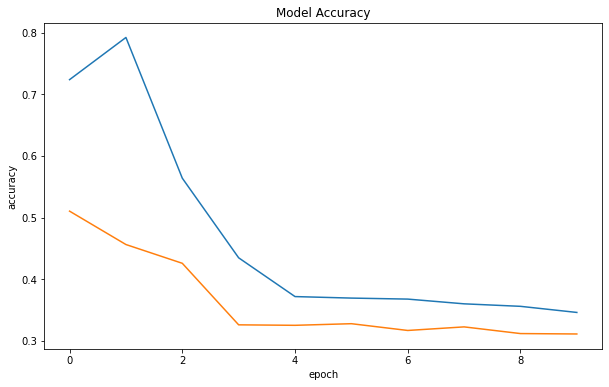

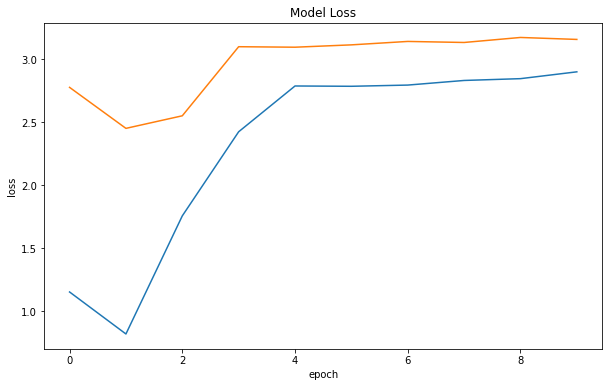

In [34]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['logits_accuracy'])
plt.plot(history.history['val_logits_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
fig.savefig(str(model_dir / 'logits_accuracy.png'), dpi=fig.dpi)

fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['logits_loss'])
plt.plot(history.history['val_logits_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
fig.savefig(str(model_dir / 'logits_loss.png'), dpi=fig.dpi)

## Testing the model with actual data

Load the tokenizer and the model first if not already loaded

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = TFGPT2LMHeadModel.from_pretrained(str(model_dir))

The function `generate_text` takes as input text, model, and tokenizer and generates top 5 texts with sampling `top_k` of 50 and `top_p` of 0.95. More on these sampling can be found on this [blog post](https://huggingface.co/blog/how-to-generate).

In [35]:
def generate_text(text, model, tokenizer):
    input_ids = tokenizer.encode(text, return_tensors='tf')
    outputs = model.predict(input_ids).logits

    print("Next most probable tokens:\n" + 100 * '-')
    for i in range(outputs.shape[1]):
        pred_id = np.argmax(outputs[:, i, :]).item()
        print(tokenizer.decode(pred_id))
    
    beam_outputs = model.generate(
        input_ids,
        max_length=100,
        num_beams=5,
        no_repeat_ngram_size=2,
        num_return_sequences=5,
        early_stopping=True,
        do_sample=True,
        top_k=50,
        top_p=0.95,
    )

    print("Beam Output:\n" + 100 * '-')
    for i, beam_output in enumerate(beam_outputs):
        print("{}: {}".format(i, tokenizer.decode(
            beam_output, skip_special_tokens=True)))

Let's test our model for different texts using this function

In [37]:
text = input("Enter text: ")
generate_text(text, model, tokenizer)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Next most probable tokens:
----------------------------------------------------------------------------------------------------
ে
 দ
ে
ে
ন


## Converting tensorflow model to tflite format

Set converter parameters to convert the model with FP16 quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.target_spec.supported_types = [tf.float16]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

Now convert the model and save as `.tflite` file

In [ ]:
tflite_model = converter.convert()
# Save the model.
with open(model_dir / 'bn_gpt2_model.tflite', 'wb') as f:
  f.write(tflite_model)

This model can be used with android applications